## Check for GPU availability
This code checks if a GPU is available and prints the GPU's name if it is. Otherwise, it prints a message indicating that no GPU is available and the CPU will be used instead.

In [1]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using GPU: NVIDIA GeForce RTX 3080


## Setting up the dataset 
It downloads and sets up a directory 'data' the first time this cell is executed

Total number of training images: 60000
Total number of testing images: 10000
Total number of training images in subset: 60000
Total number of testing images in subset: 10000
Training data range: min = 0.0, max = 1.0
Testing data range: min = 0.0, max = 1.0


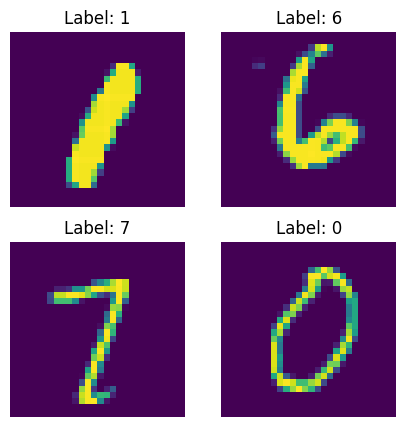

In [2]:
from mnist_loader import load_mnist, plot_sample_images

# Load the MNIST dataset
train_loader, test_loader = load_mnist(num_samples_train=60000, num_samples_test=10000, batch_size=64)  

# Plot sample images
plot_sample_images(train_loader)

## Initialize the model

In [3]:
from enhanced_vae_model import EnhancedVAE, loss_function, init_model

# Initialize the model and optimizer
model, optimizer = init_model(latent_dim=10, device=device)

## Train the model

In [4]:
from vae_training import VAETrainer, LossPlotter

# Assuming model, optimizer, train_loader, and device are already defined
trainer = VAETrainer(model, optimizer, train_loader, device, kld_weight=1.0)
train_losses = trainer.train(epochs=100, log_interval=50)

plotter = LossPlotter()
plotter.plot_losses(train_losses, scale='linear')  # Change 'linear' to 'log' for log scale

Training:   0%|          | 0/93800 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Load the model from provided PyTorch state dictionary (.pth) file

Last number in file name describes the value of used latent dimensions

In [5]:
def load_model(model, path):
    # Check if CUDA is available
    if torch.cuda.is_available():
        # Load the model weights to GPU
        state_dict = torch.load(path)
    else:
        # Load the model weights to CPU
        state_dict = torch.load(path, map_location=torch.device('cpu'))
    
    # Load the state dict into the model
    model.load_state_dict(state_dict)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Example usage
model_path = 'vae_model_gauss_enh10.pth'
try:
    model = load_model(model, model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Model loaded successfully.


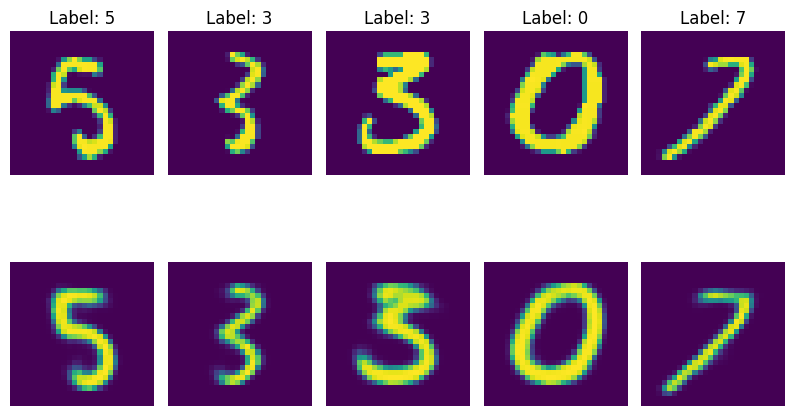

In [6]:
import random
import matplotlib.pyplot as plt

# Function to visualize results
def visualize_results(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            break

    # Randomly select num_images indices
    indices = random.sample(range(len(data)), num_images)

    # Display original and reconstructed images with labels
    plt.figure(figsize=(2 * num_images, 6))
    for i, idx in enumerate(indices):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.title(f'Label: {labels[idx].item()}')
        plt.xlabel('Original')
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.xlabel('Reconstructed')
        plt.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Example usage with variable number of images
num_images_to_display = 5
visualize_results(model, test_loader, num_images=num_images_to_display)


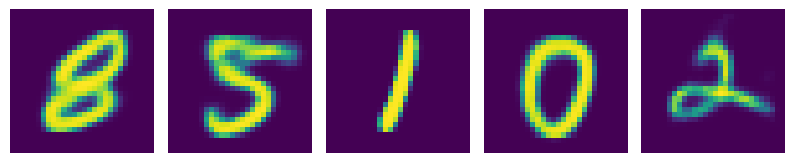

In [9]:
# Function to generate and visualize random numbers
def generate_random_numbers(model, num_samples=10):
    latent_dim_size = model.get_latent_dim()  # Get latent_dim_size from the model
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim_size).to(next(model.parameters()).device)  # Sample from a standard normal distribution
        samples = model.decode(z).cpu()
    plt.figure(figsize=(2 * num_samples, 4))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i].numpy().reshape(28, 28), cmap='viridis')
        plt.axis('off')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Generate and visualize random numbers
generate_random_numbers(model, num_samples=5)

In [7]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def extract_latent_activations(model, data_loader):
    device = next(model.parameters()).device  # Get the device from the model
    latent_dim = model.get_latent_dim()  # Get the latent dimension from the model
    model.eval()
    activations = []
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc="Extracting latent activations"):
            data = data.to(device)
            mu, logvar = model.encode(data)
            latent_space = model.reparameterize(mu, logvar)
            
            for i in range(len(labels)):
                digit = labels[i].item()
                latent_rep = latent_space[i].cpu().numpy()
                
                # Add overall latent representation
                activation_dict = {
                    'Digit': digit,
                    'Latent Representation': latent_rep
                }
                
                # Add individual neuron activations
                for j, activation in enumerate(latent_rep):
                    activation_dict[f'Latent Neuron {j}'] = j
                    activation_dict[f'Activation {j}'] = activation
                
                activations.append(activation_dict)
    
    return pd.DataFrame(activations)

# Extract latent activations
df = extract_latent_activations(model, test_loader)

# Display the first few rows of the DataFrame
display(df.head())

# Basic statistics of the activations
display(df.describe())

# You might want to save this DataFrame for further analysis
# df.to_csv('latent_activations.csv', index=False)

Extracting latent activations:   0%|          | 0/157 [00:00<?, ?it/s]

,Digit,Latent Representation,Latent Neuron 0,Activation 0,Latent Neuron 1,Activation 1,Latent Neuron 2,Activation 2,Latent Neuron 3,Activation 3,...,Latent Neuron 5,Activation 5,Latent Neuron 6,Activation 6,Latent Neuron 7,Activation 7,Latent Neuron 8,Activation 8,Latent Neuron 9,Activation 9
0,0,"[0.9956845, 0.10080308, 1.3650212, -1.2435842,...",0,0.995685,1,0.100803,2,1.365021,3,-1.243584,...,5,0.449778,6,-0.683748,7,0.544997,8,0.022453,9,0.667225
1,8,"[0.74145097, -1.3690152, 1.043644, -0.17008927...",0,0.741451,1,-1.369015,2,1.043644,3,-0.170089,...,5,-1.938221,6,-0.702924,7,-0.475720,8,-0.695548,9,-0.550148
2,4,"[0.12182009, -0.62874246, 0.3130819, 0.2335167...",0,0.121820,1,-0.628742,2,0.313082,3,0.233517,...,5,-0.327892,6,-0.448277,7,-1.817010,8,1.133873,9,-0.853909
3,3,"[1.0018563, 0.53712714, -0.42181075, -0.526412...",0,1.001856,1,0.537127,2,-0.421811,3,-0.526413,...,5,-2.337651,6,1.126420,7,-0.192935,8,-2.540088,9,-0.532357
4,0,"[0.3693324, 1.0057065, 0.9676603, -2.6308525, ...",0,0.369332,1,1.005707,2,0.967660,3,-2.630852,...,5,-0.166672,6,-0.315429,7,-0.847607,8,-0.871737,9,-0.201926


,Digit,Latent Neuron 0,Activation 0,Latent Neuron 1,Activation 1,Latent Neuron 2,Activation 2,Latent Neuron 3,Activation 3,Latent Neuron 4,...,Latent Neuron 5,Activation 5,Latent Neuron 6,Activation 6,Latent Neuron 7,Activation 7,Latent Neuron 8,Activation 8,Latent Neuron 9,Activation 9
count,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,...,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000
mean,4.443400,0.0,-0.005781,1.0,-0.101150,2.0,-0.060763,3.0,-0.022290,4.0,...,5.0,0.037106,6.0,0.026482,7.0,0.027059,8.0,-0.004266,9.0,-0.048238
std,2.895865,0.0,1.012956,0.0,1.007602,0.0,1.026885,0.0,1.001279,0.0,...,0.0,1.007681,0.0,1.016802,0.0,0.972643,0.0,1.045614,0.0,1.010197
min,0.000000,0.0,-4.570428,1.0,-4.204395,2.0,-3.815254,3.0,-3.809343,4.0,...,5.0,-3.453216,6.0,-3.358293,7.0,-4.405526,8.0,-3.945640,9.0,-4.399792
25%,2.000000,0.0,-0.685037,1.0,-0.798567,2.0,-0.761380,3.0,-0.674095,4.0,...,5.0,-0.651926,6.0,-0.708377,7.0,-0.592986,8.0,-0.754100,9.0,-0.713179
50%,4.000000,0.0,0.004726,1.0,-0.086135,2.0,-0.045424,3.0,-0.066151,4.0,...,5.0,0.033140,6.0,0.037459,7.0,0.030104,8.0,-0.045832,9.0,-0.058860
75%,7.000000,0.0,0.679896,1.0,0.601090,2.0,0.630066,3.0,0.570696,4.0,...,5.0,0.715721,6.0,0.752889,7.0,0.677449,8.0,0.713496,9.0,0.609715
max,9.000000,0.0,3.897871,1.0,3.619448,2.0,2.964026,3.0,2.992393,4.0,...,5.0,3.620554,6.0,3.929973,7.0,3.788234,8.0,3.909590,9.0,4.321852


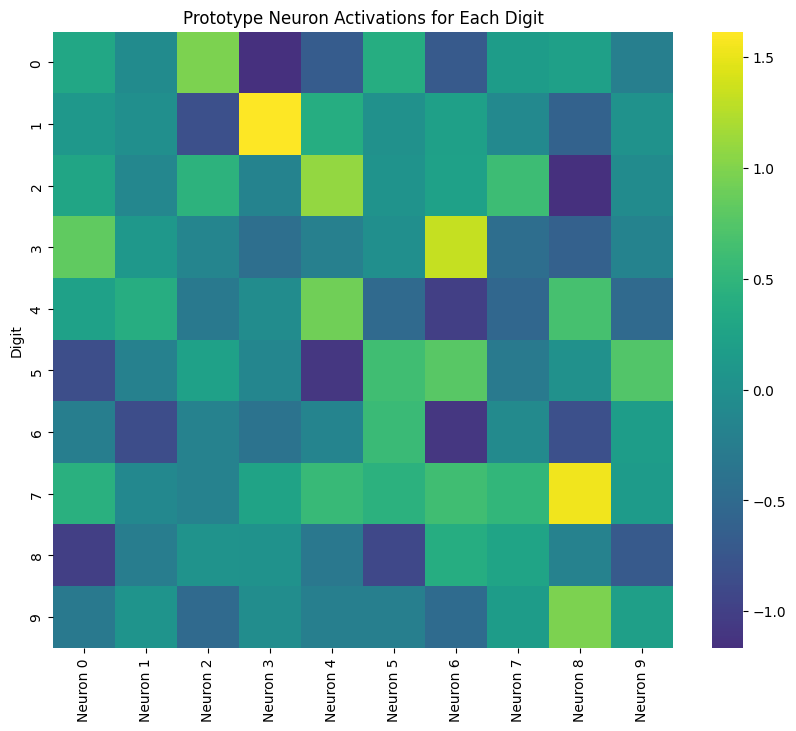

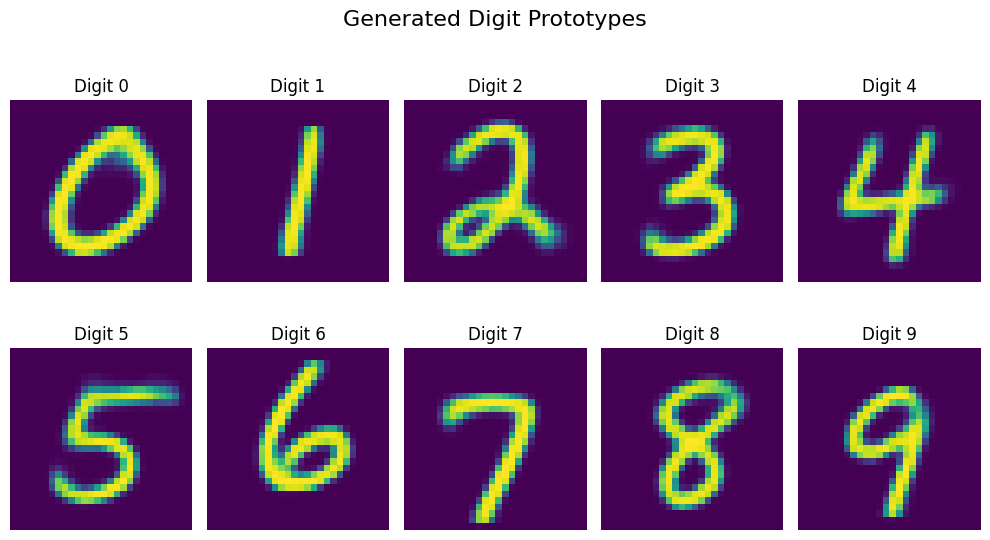

Digit 0:
neuron_values = {
    0: 0.308555,
    1: -0.064160,
    2: 0.965239,
    3: -1.164572,
    4: -0.679200,
    5: 0.387299,
    6: -0.718769,
    7: 0.157077,
    8: 0.209437,
    9: -0.241130,
}

Digit 1:
neuron_values = {
    0: 0.113167,
    1: -0.021263,
    2: -0.827694,
    3: 1.615070,
    4: 0.385404,
    5: 0.004447,
    6: 0.205598,
    7: -0.100442,
    8: -0.605656,
    9: 0.033601,
}

Digit 2:
neuron_values = {
    0: 0.286409,
    1: -0.116093,
    2: 0.454476,
    3: -0.171823,
    4: 1.083852,
    5: 0.051394,
    6: 0.222545,
    7: 0.601464,
    8: -1.161078,
    9: -0.070922,
}

Digit 3:
neuron_values = {
    0: 0.826207,
    1: 0.105885,
    2: -0.150434,
    3: -0.442191,
    4: -0.218925,
    5: -0.022131,
    6: 1.332314,
    7: -0.457475,
    8: -0.627678,
    9: -0.170444,
}

Digit 4:
neuron_values = {
    0: 0.222889,
    1: 0.395153,
    2: -0.297458,
    3: -0.055808,
    4: 0.916525,
    5: -0.509675,
    6: -1.004362,
    7: -0.536526,
    8: 0.665

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np

def calculate_digit_prototypes(df):
    # Extract the activation columns
    activation_columns = [col for col in df.columns if col.startswith('Activation')]
    
    # Compute average activations per neuron per digit
    prototypes = df.groupby('Digit')[activation_columns].mean()
    
    # Rename columns to match the original format
    prototypes.columns = [f'Neuron {i}' for i in range(len(activation_columns))]
    
    return prototypes

def generate_prototype_images(model, prototypes):
    device = next(model.parameters()).device  # Get the device from the model
    model.eval()
    with torch.no_grad():
        # Convert prototypes to tensor
        prototype_tensors = torch.tensor(prototypes.values, dtype=torch.float32).to(device)
        
        # Generate images
        generated_images = model.decode(prototype_tensors).cpu().numpy()
        
        # Plot the generated images
        fig, axes = plt.subplots(2, 5, figsize=(10, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i].reshape(28, 28), cmap='viridis')
            ax.set_title(f"Digit {i}")
            ax.axis('off')
        
        plt.suptitle("Generated Digit Prototypes", fontsize=16)
        plt.tight_layout()
        plt.show()

# Calculate prototypes
prototypes = calculate_digit_prototypes(df)

# Display the prototypes as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(prototypes, cmap='viridis', center=0, annot=False, fmt='.2f')
plt.title('Prototype Neuron Activations for Each Digit')
plt.ylabel('Digit')
plt.show()

# Generate and display prototype images
generate_prototype_images(model, prototypes)

# Print the prototype values for each digit in the specified format
for digit in range(10):
    print(f"Digit {digit}:")
    print(f"neuron_values = {{")
    for neuron_index, (neuron, value) in enumerate(prototypes.loc[digit].items()):
        print(f"    {neuron_index}: {value:.6f},")
    print("}\n")

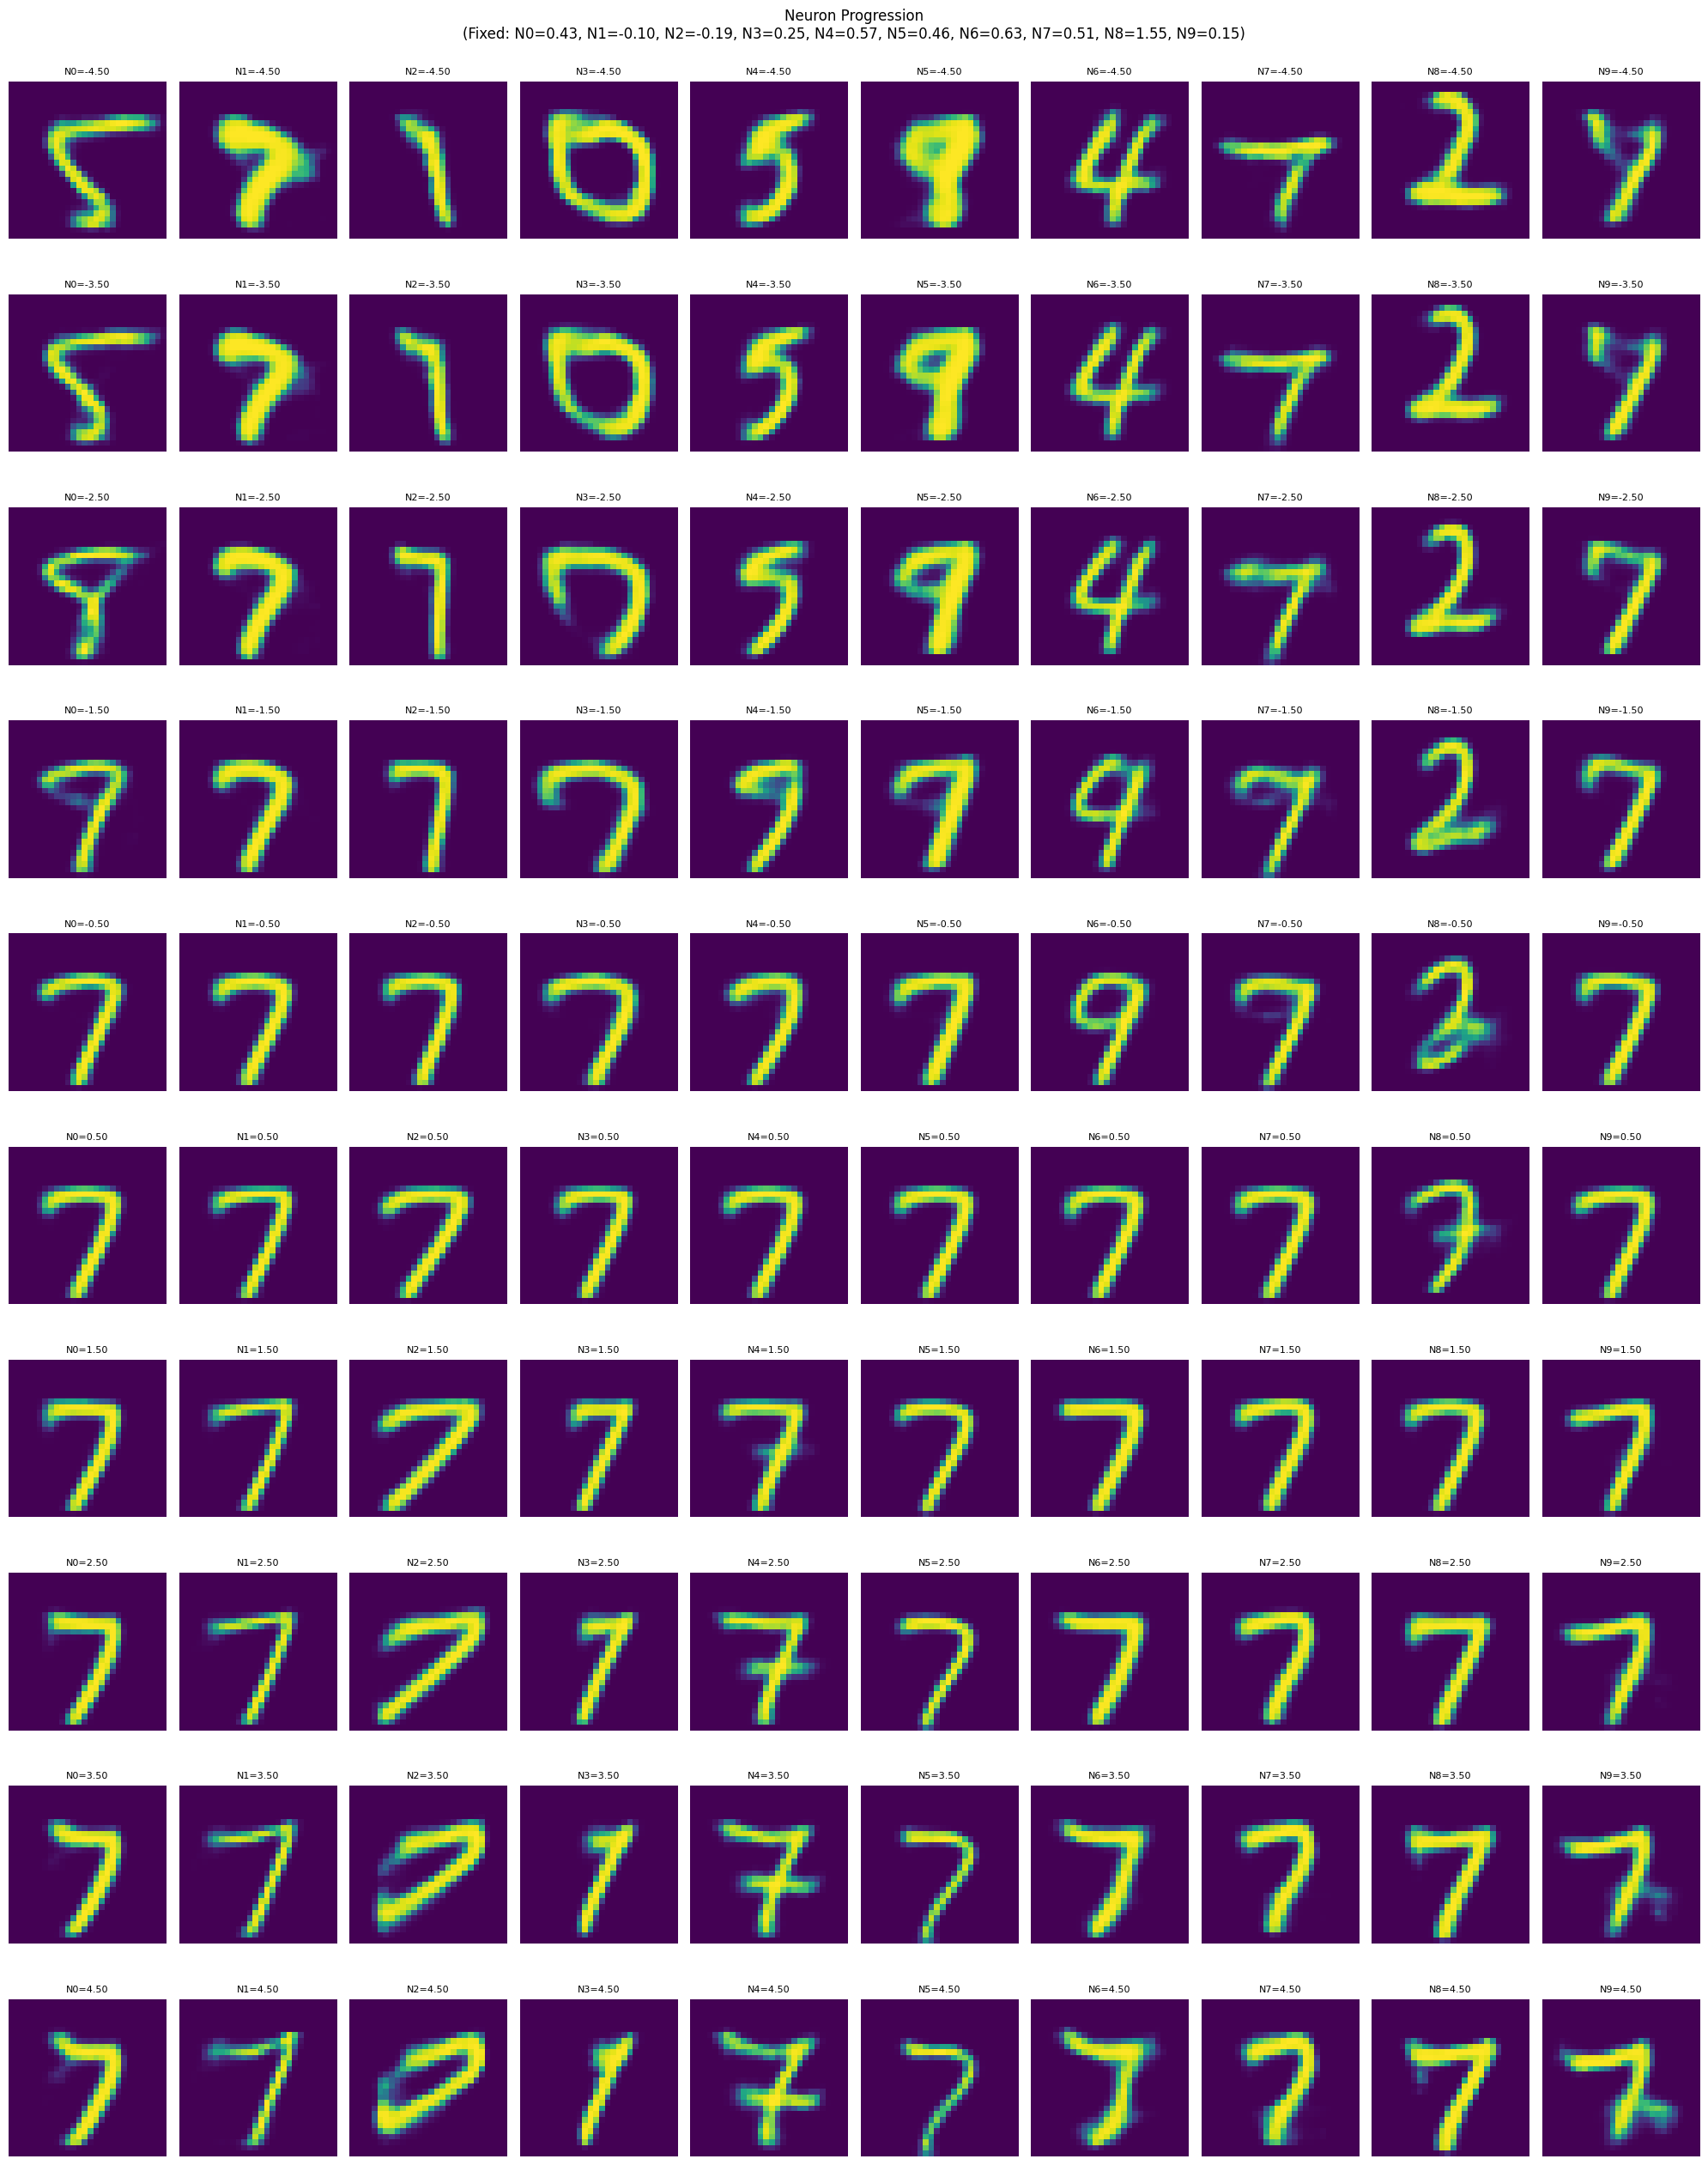

In [9]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Normal

def generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=16, steps=11, start_value=-2, end_value=2):
    device = next(model.parameters()).device  # Get the device from the model
    model.eval()
    with torch.no_grad():
        dist = Normal(0, 1)
        
        if neurons_to_iterate is all:
            neurons_to_iterate = list(neuron_values.keys())
        elif not isinstance(neurons_to_iterate, list):
            neurons_to_iterate = [neurons_to_iterate]
        
        num_neurons = len(neurons_to_iterate)
        fig, axes = plt.subplots(steps, num_neurons, figsize=(num_neurons*2, steps*2.5))  # Increased figure height
        
        # Ensure axes is always a 2D array
        if num_neurons == 1:
            axes = axes[:, None]
        
        for step in range(steps):
            z = dist.sample((num_images, model.get_latent_dim())).to(device)
            
            for neuron, value in neuron_values.items():
                z[:, neuron] = value
            
            iterated_value = start_value + (end_value - start_value) * step / (steps - 1)
            
            for col, neuron_to_iterate in enumerate(neurons_to_iterate):
                z_neuron = z.clone()
                z_neuron[:, neuron_to_iterate] = iterated_value
                
                generated_images = model.decode(z_neuron).cpu()
                
                ax = axes[step, col]
                ax.imshow(generated_images[0].squeeze(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f"N{neuron_to_iterate}={iterated_value:.2f}", fontsize=8)  # Reduced font size
        
        manipulated_info = ", ".join([f"N{n}={v:.2f}" for n, v in neuron_values.items()])
        plt.suptitle(f"Neuron Progression\n(Fixed: {manipulated_info})", fontsize=12, y=1.02)  # Added line break and adjusted y position
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.999)  # Adjust top margin
        plt.show()

# Example usage:
neuron_values = {
    0: 0.429669,
    1: -0.097193,
    2: -0.193509,
    3: 0.252150,
    4: 0.570354,
    5: 0.455989,
    6: 0.626408,
    7: 0.511400,
    8: 1.546883,
    9: 0.147519,
}
neurons_to_iterate = all  # Use 'all' to iterate over all neurons in neuron_values, a single neuron number or a list can be used as well
start_value = -4.5  # Start of the range
end_value = 4.5  # End of the range
generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=1, steps=10, start_value=start_value, end_value=end_value)

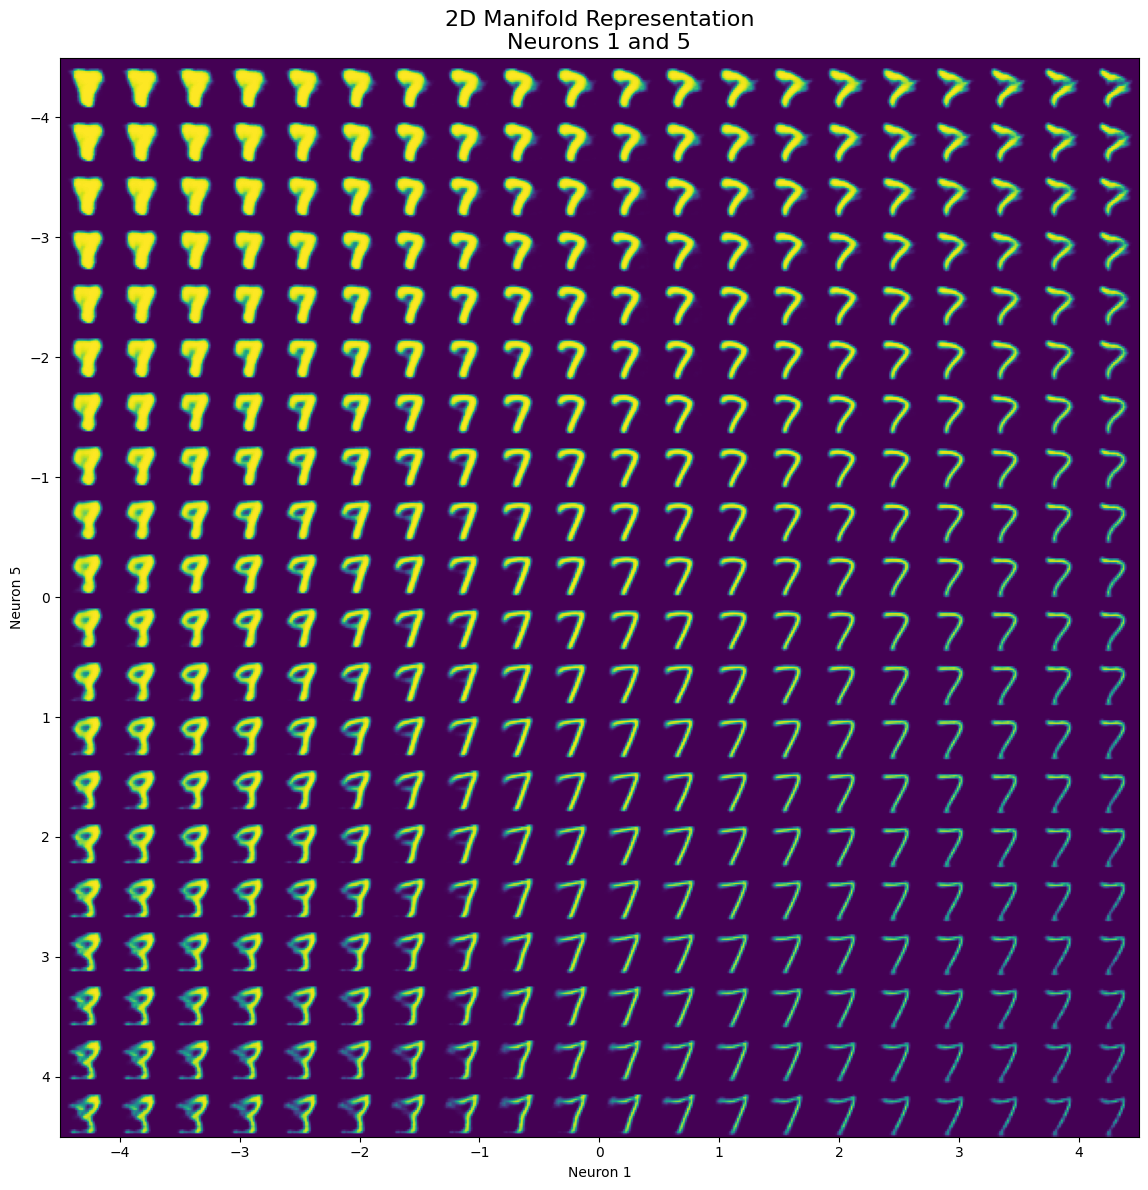

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Normal
import numpy as np

def generate_2d_manifold(model, neuron1, neuron2, neuron_values, num_images=16, steps=11, start_value=-2, end_value=2):
    model.eval()
    with torch.no_grad():
        dist = Normal(0, 1)
        
        fig, ax = plt.subplots(figsize=(12, 12))
        
        images = []
        for i, value1 in enumerate(torch.linspace(start_value, end_value, steps)):
            row_images = []
            for j, value2 in enumerate(torch.linspace(start_value, end_value, steps)):
                z = dist.sample((num_images, model.latent_dim)).to(device)
                
                for neuron, value in neuron_values.items():
                    z[:, neuron] = value
                
                z[:, neuron1] = value1
                z[:, neuron2] = value2
                
                generated_image = model.decode(z).cpu()
                row_images.append(generated_image[0].squeeze().numpy())
            
            images.append(row_images)
        
        # Combine all images into a single array
        combined_image = np.concatenate([np.concatenate(row, axis=1) for row in images], axis=0)
        
        # Display the combined image
        im = ax.imshow(combined_image, cmap='viridis', extent=[start_value, end_value, end_value, start_value])
        
        # Set labels and title
        ax.set_xlabel(f'Neuron {neuron1}')
        ax.set_ylabel(f'Neuron {neuron2}')
        ax.set_title(f'2D Manifold Representation\nNeurons {neuron1} and {neuron2}', fontsize=16)
        
        # Remove grid lines
        ax.grid(False)
        
        # Remove color bar (legend)
        # plt.colorbar(im, ax=ax, label='Pixel values')
        
        plt.tight_layout()
        plt.show()

# Example usage:
neuron_values = {
    0: 0.429669,
    1: -0.097193,
    2: -0.193509,
    3: 0.252150,
    4: 0.570354,
    5: 0.455989,
    6: 0.626408,
    7: 0.511400,
    8: 1.546883,
    9: 0.147519,
}

# Select two neurons to visualize
neuron1 = 1  # Change this to your desired neuron
neuron2 = 5  # Change this to your desired neuron

start_value = -4.5
end_value = 4.5

generate_2d_manifold(model, neuron1, neuron2, neuron_values, num_images=1, steps=20, start_value=start_value, end_value=end_value)


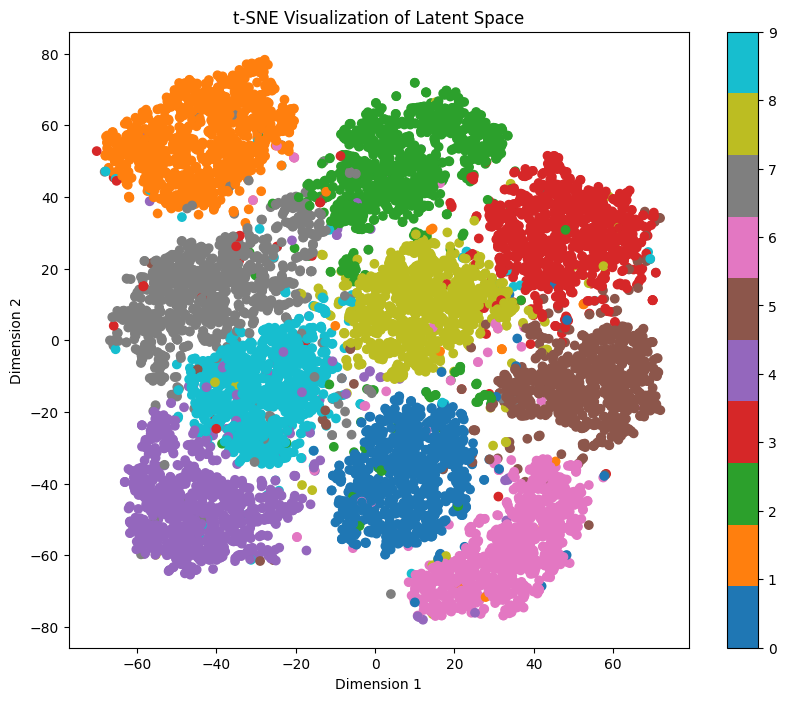

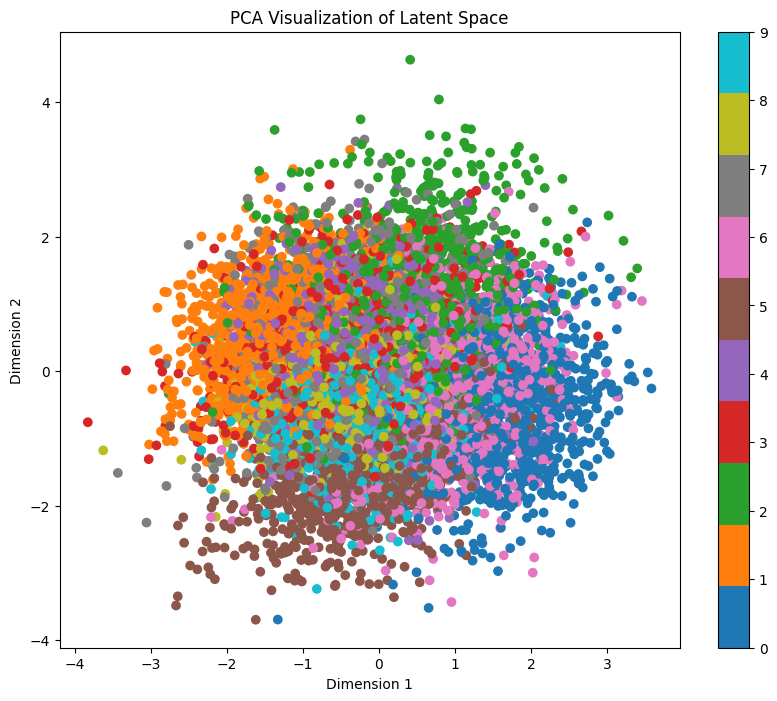

PCA explained variance ratio: [0.12037192 0.11842815]


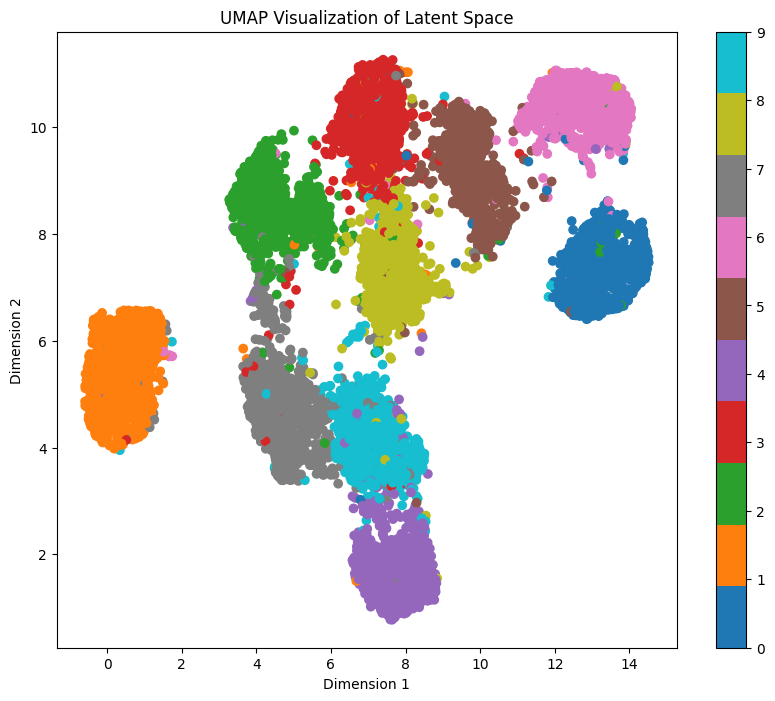

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler

def plot_embedding(X, y, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

def create_visualizations(df):
    # Extract latent representations
    latent_cols = [col for col in df.columns if col.startswith('Activation')]
    X = df[latent_cols].values
    y = df['Digit'].values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    plot_embedding(X_tsne, y, 't-SNE Visualization of Latent Space')

    # PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    plot_embedding(X_pca, y, 'PCA Visualization of Latent Space')

    # Print explained variance ratio for PCA
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

    # UMAP
    umap_model = UMAP(n_components=2, random_state=42, n_jobs=1)
    X_umap = umap_model.fit_transform(X_scaled)
    plot_embedding(X_umap, y, 'UMAP Visualization of Latent Space')



# Assuming df is your DataFrame from the previous step
create_visualizations(df)

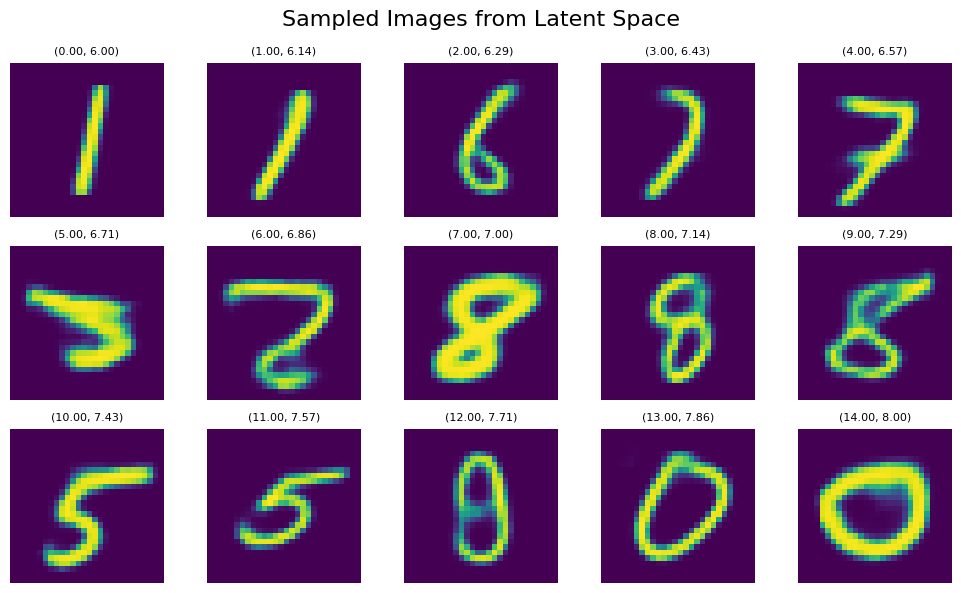

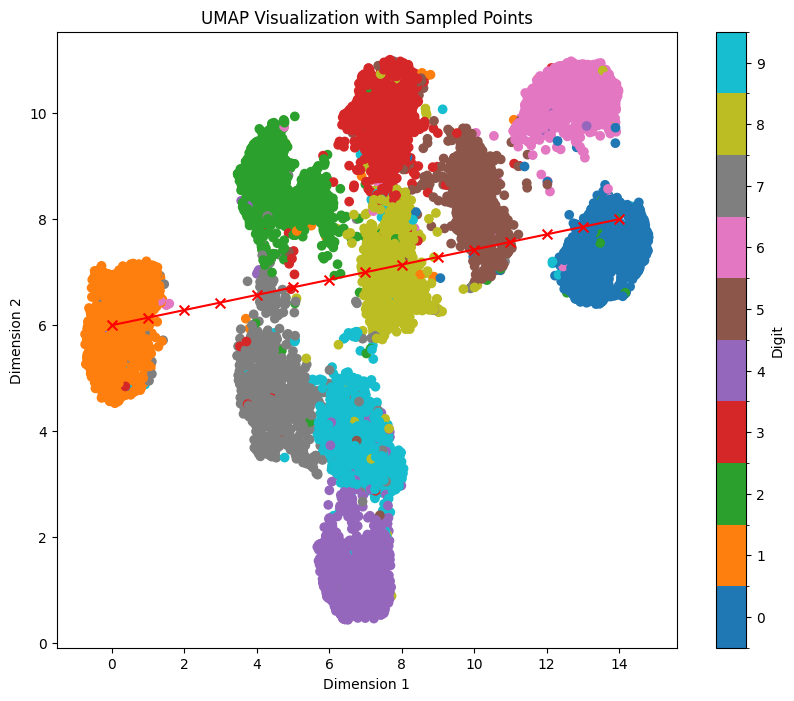

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import torch

def sample_and_visualize_latent_space(df, model, device, method='umap', sampling_points=None, line_start=None, line_end=None, n_line_samples=10):
    # Extract latent representations
    latent_cols = [col for col in df.columns if col.startswith('Activation')]
    X = df[latent_cols].values
    y = df['Digit'].values

    # Perform dimensionality reduction
    if method == 'umap':
        reducer = UMAP(n_components=2, random_state=42, n_jobs=1)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be one of 'umap', 'tsne', or 'pca'")
    
    X_reduced = reducer.fit_transform(X)

    # Define sampling points
    if sampling_points:
        grid_points = np.array(sampling_points)
    elif line_start and line_end:
        grid_points = np.linspace(np.array(line_start), np.array(line_end), n_line_samples)
    else:
        raise ValueError("Either sampling_points or line_start and line_end must be provided.")

    # Find nearest neighbors in reduced space
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(X_reduced)
    _, indices = nn.kneighbors(grid_points)

    # Get corresponding latent space points
    sampled_latent_points = X[indices.flatten()]

    # Generate images from sampled latent points
    model.eval()
    with torch.no_grad():
        latent_tensor = torch.FloatTensor(sampled_latent_points).to(device)
        generated_images = model.decode(latent_tensor).cpu().numpy()

    # Visualize generated images with coordinates
    n_samples = len(grid_points)
    n_cols = min(5, n_samples)
    n_rows = (n_samples - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    fig.suptitle("Sampled Images from Latent Space", fontsize=16)

    for idx, ax in enumerate(axes.flatten()):
        if idx < n_samples:
            ax.imshow(generated_images[idx].reshape(28, 28), cmap='viridis')
            ax.axis('off')
            coord = grid_points[idx]
            ax.set_title(f"({coord[0]:.2f}, {coord[1]:.2f})", fontsize=8)
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

    # Define colors for plotting
    n_classes = len(np.unique(y))
    cmap = mpl.colormaps['tab10']
    norm = BoundaryNorm(np.arange(-0.5, n_classes + 0.5, 1), n_classes)

    # Plot reduced space with sampling points
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=cmap, norm=norm)
    plt.colorbar(scatter, ticks=np.arange(n_classes), label='Digit')
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c='red', s=50, marker='x')
    
    if line_start and line_end:
        plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'r-')
    
    plt.title(f'{method.upper()} Visualization with Sampled Points')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and model is your VAE

# Option 1: Custom points
# custom_points = [
#     [-4, 7], [-2, 7], [0, 7], [2, 7], [4, 7],
#     [-4, 0], [-2, 0], [0, 0], [2, 0], [4, 0],
#     [-4, -7], [-2, -7], [0, -7], [2, -7], [4, -7]
# ]
# sample_and_visualize_latent_space(df, model, device, method='tsne', sampling_points=custom_points)

# Option 2: Line sampling
line_start = [0, 6]
line_end = [14, 8]
sample_and_visualize_latent_space(df, model, device, method='umap', line_start=line_start, line_end=line_end, n_line_samples=15)
